In [1]:
from bin import load_bgi as ld

import scanpy as sc
import squidpy as sq
import anndata as ad
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import scipy.sparse as sp

In [2]:
from bin import SCC as scc

In [135]:
gdata = ld.load_bin(gem_file="gRNA/B924/D03658A3-merged.gem.bin_200",
                    bin_size=1,
                    library_id="gRNA")
sgs = gdata.var_names.str.split('_', n=1).str[0]
sgs_grouped = pd.DataFrame(gdata.X.toarray(), columns=gdata.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()
sgdata = ad.AnnData(sgs_grouped, obs=gdata.obs, var=pd.DataFrame(index=sgs_grouped.columns))
sgdata.obsm['spatial'] = gdata.obsm['spatial']
sgdata

AnnData object with n_obs × n_vars = 8539 × 34
    obsm: 'spatial'

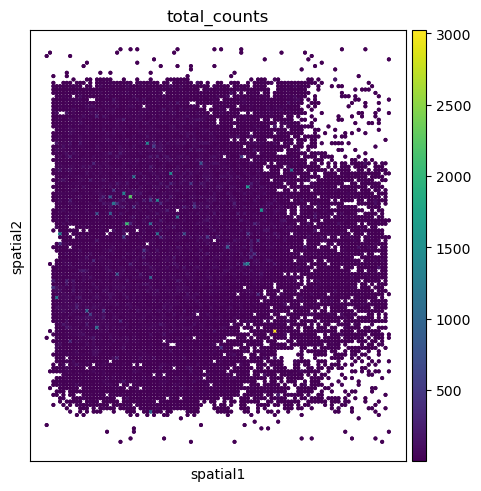

In [136]:
sc.pp.calculate_qc_metrics(sgdata,percent_top=None, log1p=False, inplace=True)
sq.pl.spatial_scatter(sgdata,shape=None,color=["total_counts",],library_id='gRNA')

In [84]:
grna_per_bin = np.sum(sgdata.obs["total_counts"]) / len(sgdata.obs["total_counts"])
grna_per_bin

7.237623880138189

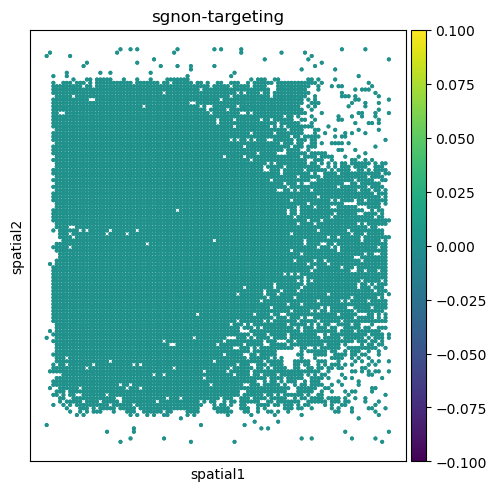

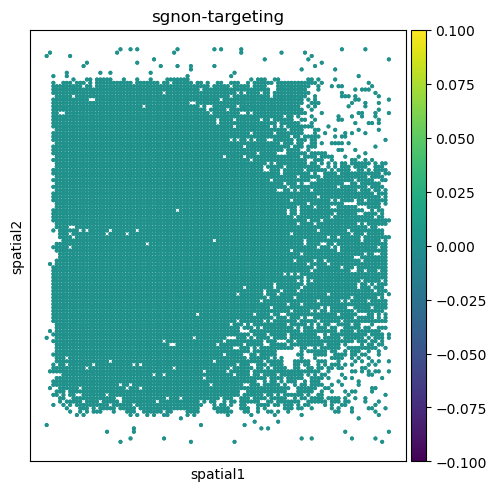

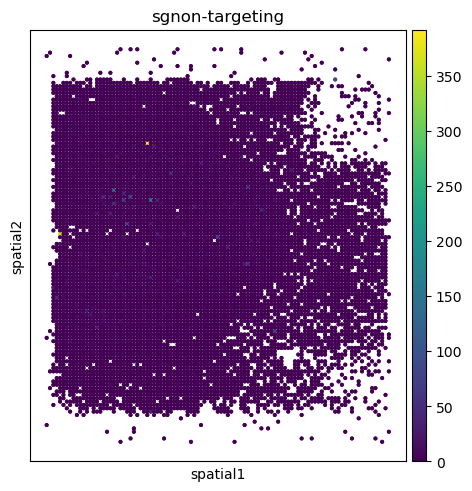

In [138]:
NTC_vec = sgdata[:, "sgnon-targeting"].X.toarray().flatten()
ntc_matrix = np.zeros((len(NTC_vec), 34))
for i in range(34):
    ntc_matrix[:, i] = NTC_vec
NTC = ntc_matrix
sgdata.layers["log_NTC"] = np.asarray(np.log2(sgdata.X + 1e-20) - np.log2(NTC + 1e-20))

NTC_vec = sgdata[:, "sgnon-targeting"].X.toarray().flatten()
ntc_matrix = np.zeros((len(NTC_vec), 34))
for i in range(34):
    ntc_matrix[:, i] = NTC_vec
NTC = ntc_matrix
sgdata.layers["raw_NTC"] = np.asarray(sgdata.X - NTC)

sq.pl.spatial_scatter(sgdata,shape=None,color="sgnon-targeting", layer="log_NTC",library_id='gRNA')
sq.pl.spatial_scatter(sgdata,shape=None,color="sgnon-targeting", layer="raw_NTC",library_id='gRNA')
sq.pl.spatial_scatter(sgdata,shape=None,color="sgnon-targeting", layer="X",library_id='gRNA')

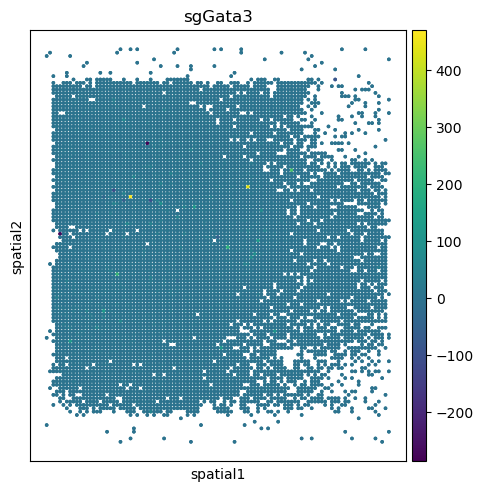

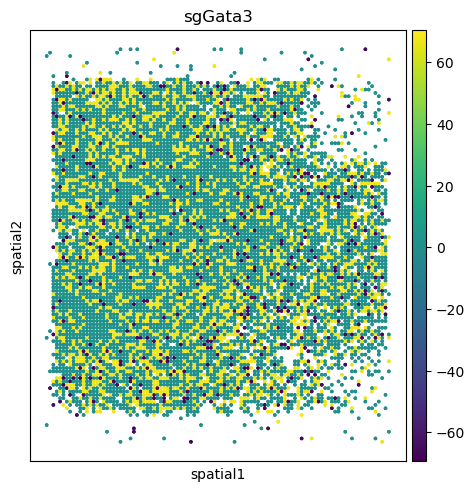

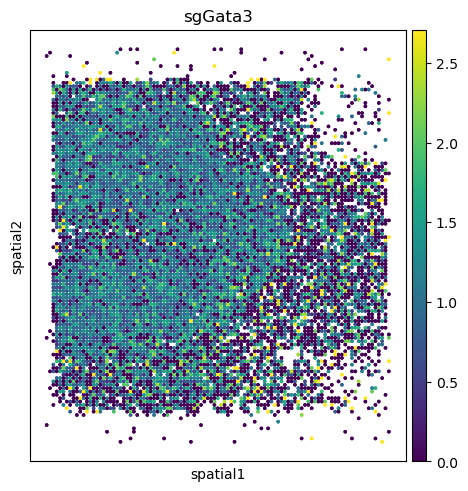

In [139]:
sc.pp.normalize_total(sgdata)
sc.pp.log1p(sgdata)

sq.pl.spatial_scatter(sgdata, layer="raw_NTC", color=["sgGata3"], size=10, shape=None)
sq.pl.spatial_scatter(sgdata, layer="log_NTC", color=["sgGata3"], size=10, shape=None)
sq.pl.spatial_scatter(sgdata, layer="X", color=["sgGata3"], size=10, shape=None)

In [141]:
sgdata.obsm["ntc_pca"] = sc.pp.pca(sgdata.layers["raw_NTC"])
sgdata.obsm["logntc_pca"] = sc.pp.pca(sgdata.layers["log_NTC"])
sgdata.obsm["pca"] = sc.pp.pca(sgdata.X)

In [143]:
scc.scc(sgdata, key_added="scc", pca_key="pca", resolution=0.5)
scc.scc(sgdata, key_added="ntc_scc", pca_key="ntc_pca", resolution=0.5)
scc.scc(sgdata, key_added="logntc_scc", pca_key="logntc_pca", resolution=0.5)

using adj_matrix from arg for clustering...
using adj_matrix from arg for clustering...
using adj_matrix from arg for clustering...


In [55]:
sgdata.obs["scc_colors"] = None

In [18]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
adata

AnnData object with n_obs × n_vars = 6400 × 27367
    uns: 'log1p', 'pca'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'

In [67]:
colors = plt.get_cmap("flare")
n_colors = len(np.unique(sgdata.obs["scc"]))
sgdata.uns["scc_colors"] = colors([int(256 / n_colors) * i for i in range(len(np.unique(sgdata.obs["scc"])))])

In [60]:
sgdata

AnnData object with n_obs × n_vars = 8539 × 34
    obs: 'scc', 'ntc_scc', 'logntc_scc', 'scc_colors'
    uns: 'log1p', 'pca', 'neighbors', 'spatial_neighbors', 'scc', 'scc_colors', 'rank_genes_groups', 'ntc_scc', 'logntc_scc'
    obsm: 'spatial', 'X_pca', 'ntc_pca', 'logntc_pca'
    varm: 'PCs'
    layers: 'log_NTC', 'raw_NTC'
    obsp: 'distances', 'connectivities', 'spatial_distances', 'spatial_connectivities'

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


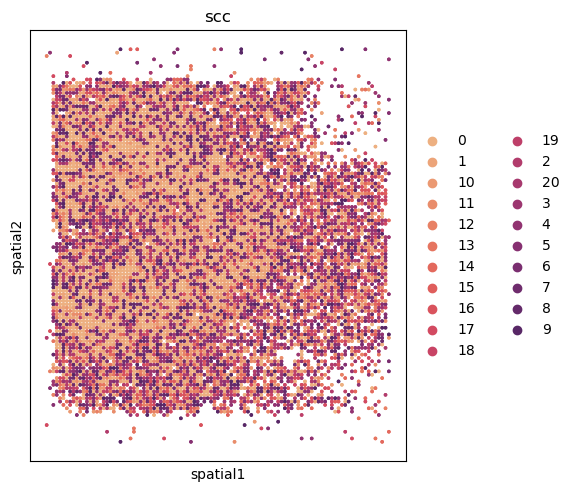

In [68]:
fig, ax = plt.subplots(1, 3, figsize=(5,5))
sq.pl.spatial_scatter(sgdata, color=["scc",], size=10, shape=None, fig=ax)

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:434: PerformanceWa

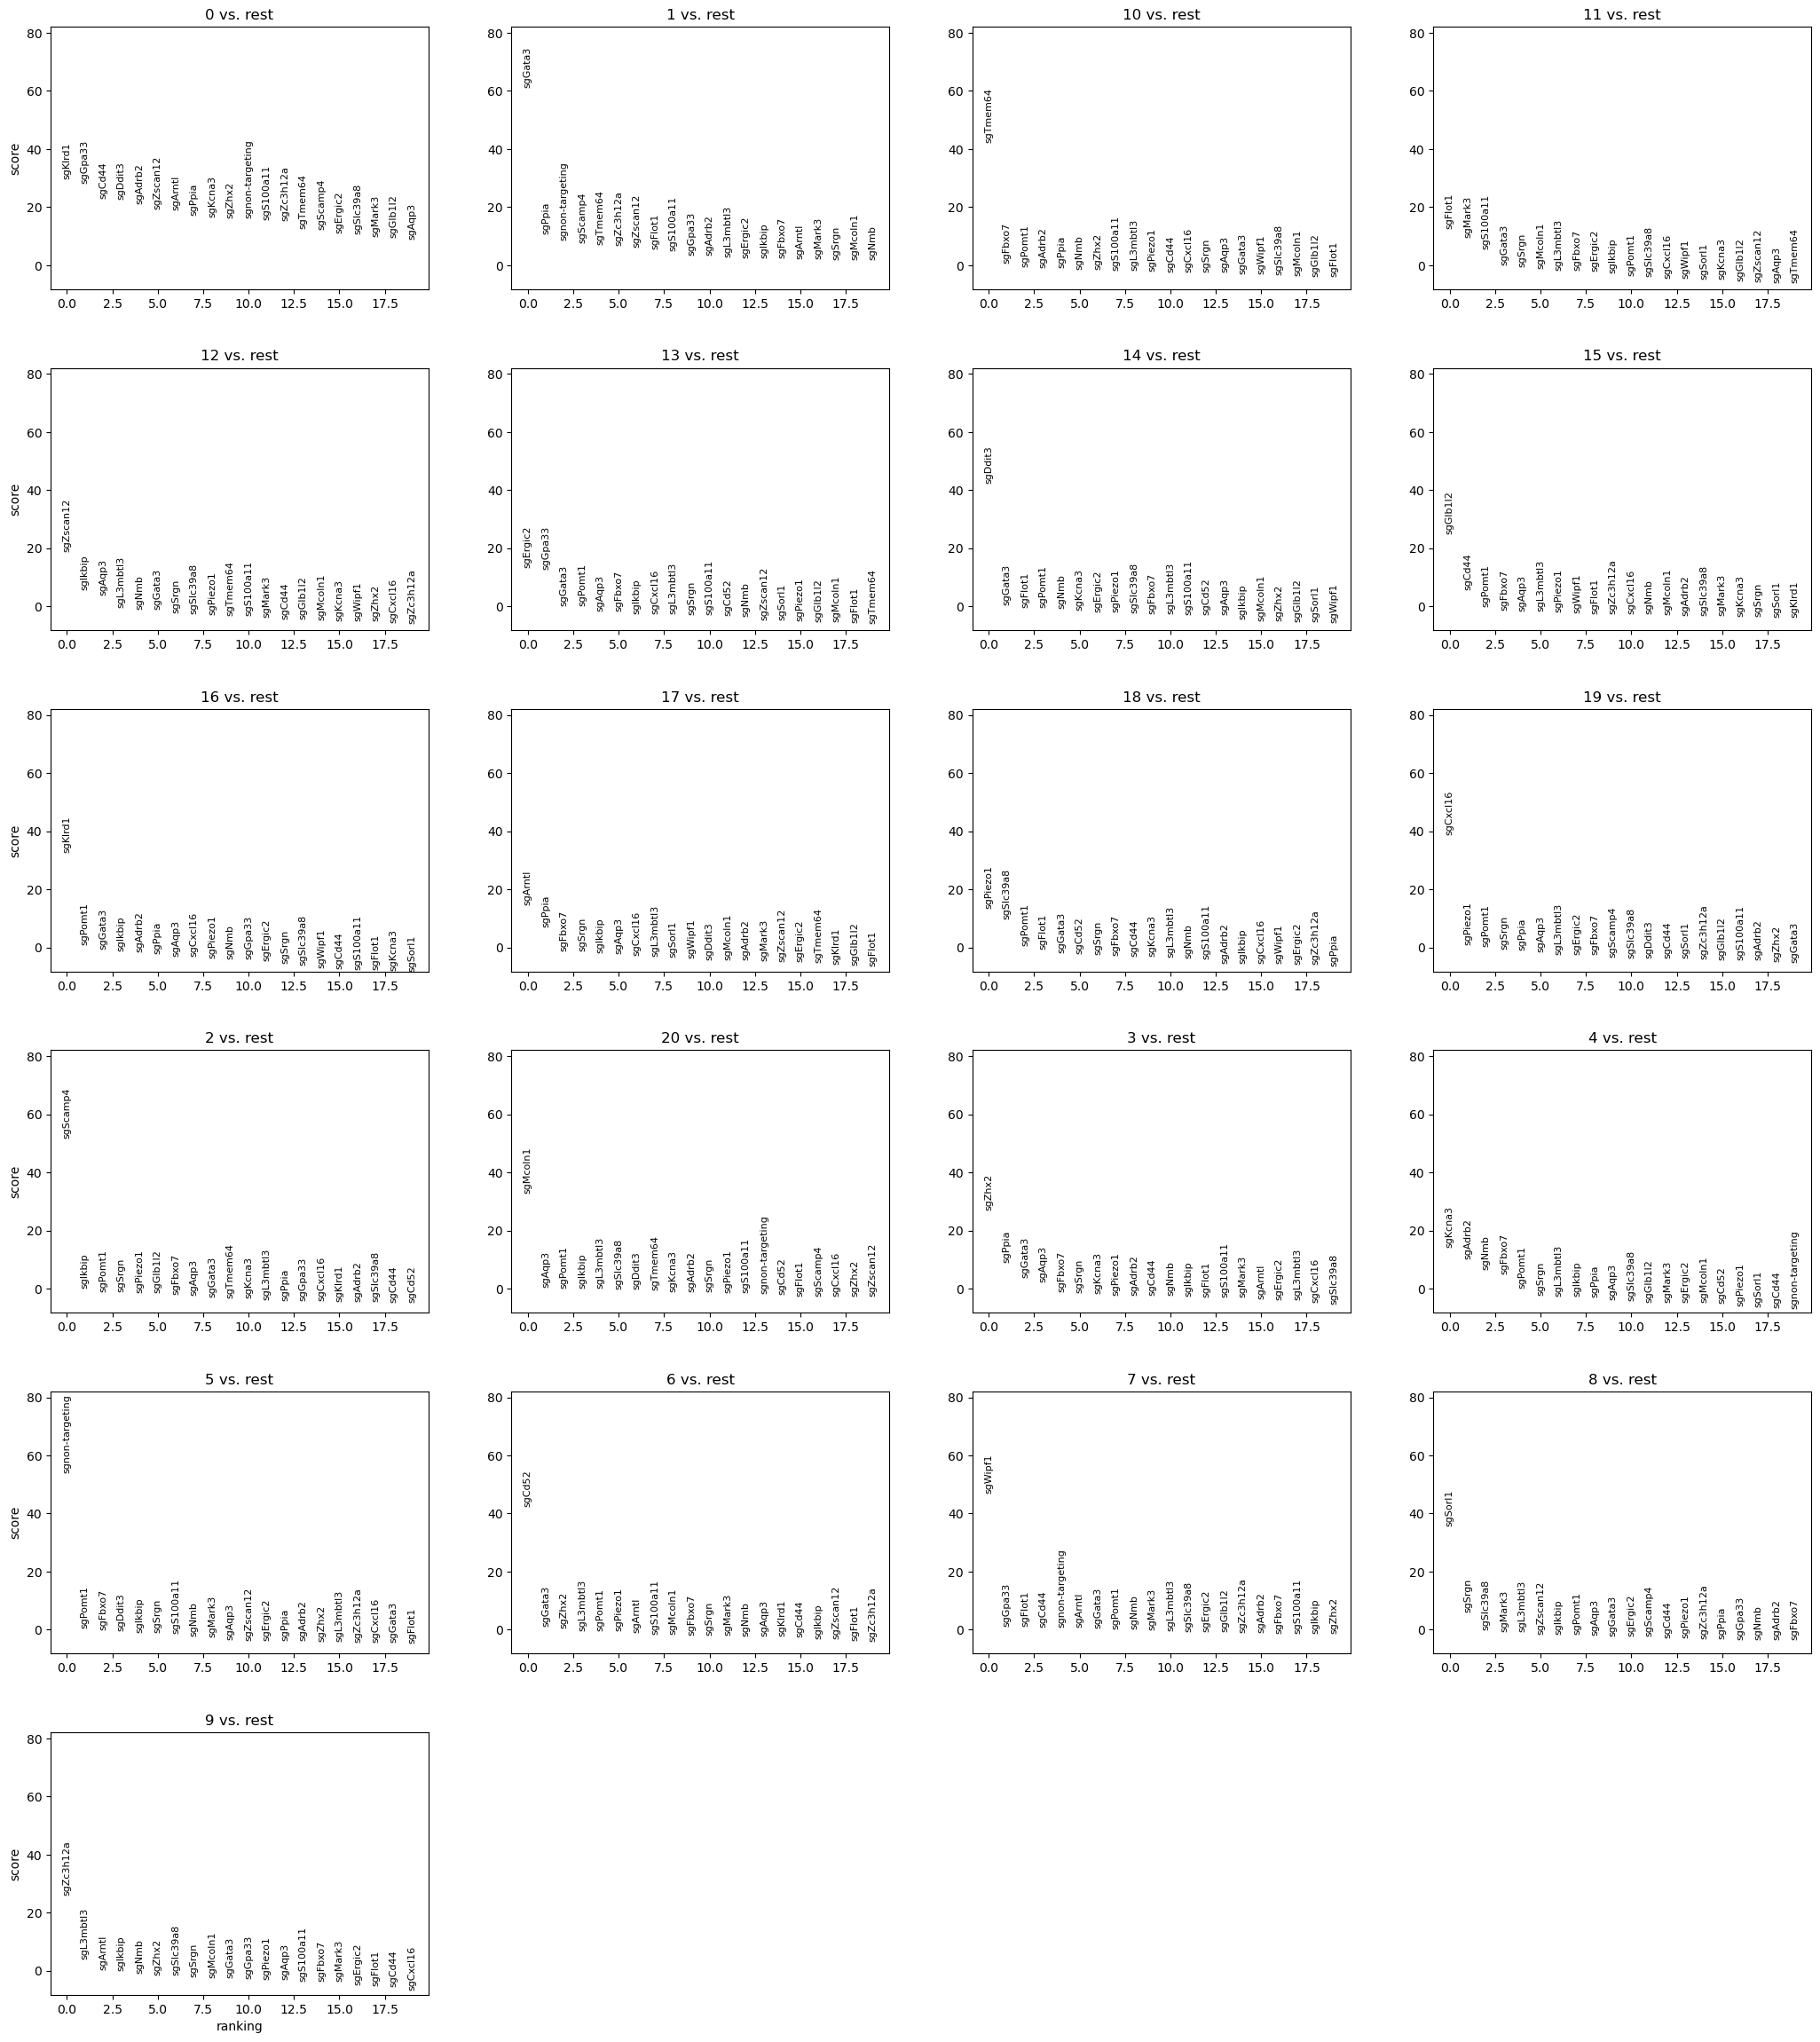

In [69]:
sc.tl.rank_genes_groups(sgdata, groupby="scc")
sc.pl.rank_genes_groups(sgdata, groupby="scc")

In [202]:
sc.pl.embedding(sgdata, basis="spatial3d", projection="3d", color=["sgnon-targeting", "sgGata3"])

KeyError: "Could not find 'spatial3d' or 'X_spatial3d' in .obsm"